Solution 1:
 [['1' '0']
 ['0' '1']]

Solution 2:
 [['1' '1']
 ['1' '0']]

None <_io.TextIOWrapper name='reports/Sudoku_2x2/1024_DRM/solutions_20250113_155241.txt' mode='a' encoding='UTF-8'>


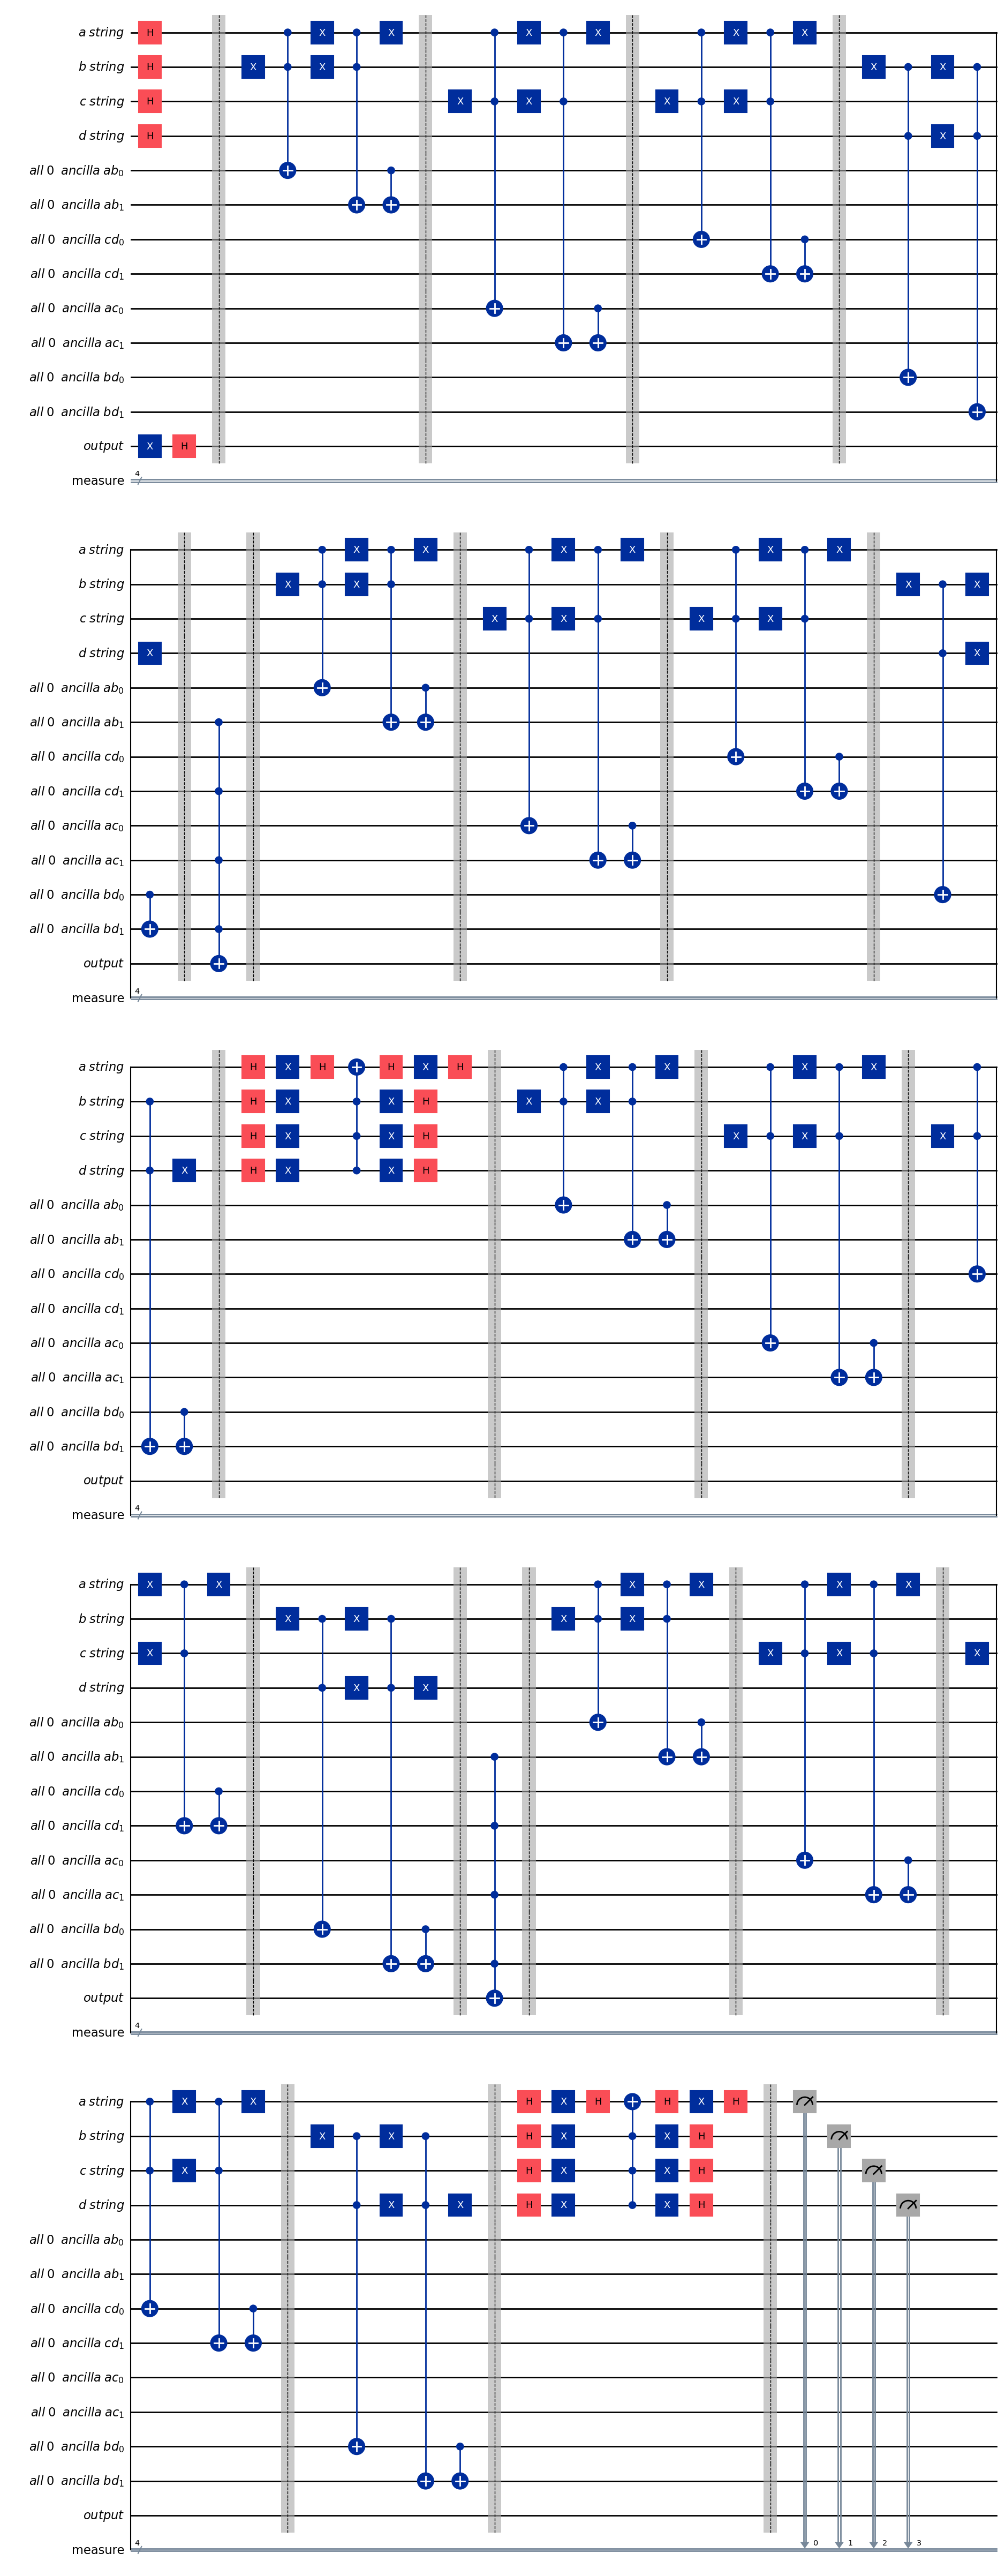

In [ ]:
from datetime import datetime
from operator import itemgetter
import numpy as np
import os
import sys

from qiskit import *
from qiskit import qpy
from qiskit_aer import QasmSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from qiskit.visualization import plot_histogram

# Flags for enabling specific errors noises
depolarization_error_on = True
relaxation_error_on = True
measurement_error_on = True

iterations = 1024

# Define quantum registers
clause_list = [[0, 1], [0, 2], [1, 3], [2, 3]]

a_string = QuantumRegister(1, name='a string')
b_string = QuantumRegister(1, name='b string')
c_string = QuantumRegister(1, name='c string')
d_string = QuantumRegister(1, name='d string')

all_0_ancilla_ab = QuantumRegister(2, name='all 0  ancilla ab')
all_0_ancilla_cd = QuantumRegister(2, name='all 0  ancilla cd')
all_0_ancilla_ac = QuantumRegister(2, name='all 0  ancilla ac')
all_0_ancilla_bd = QuantumRegister(2, name='all 0  ancilla bd')

out = QuantumRegister(1,name='output')

classical = ClassicalRegister(4, name='measure')

# Create quantum circuit
qc = QuantumCircuit(a_string, b_string, c_string, d_string, all_0_ancilla_ab,
                    all_0_ancilla_cd, all_0_ancilla_ac, all_0_ancilla_bd, out, classical)

# Initialize quantum circuit
qc.x(out)
qc.h(out)

# Superposition of input
qc.h(a_string[0])
qc.h(b_string[0])
qc.h(c_string[0])
qc.h(d_string[0])
qc.barrier()

#se entrambi i bit sono a 1 pongo l'output a uno
def compare(qc, string, neg_string, save_output):
    qc.x(neg_string)
    qc.mcx([string, neg_string], save_output)
    qc.x(neg_string)

def oracle(qc):
    # Comparator ab
    #se i due bit sono diversi all_0_ancilla_ab conterrà almeno una posizione a 1
    compare(qc, a_string[0], b_string[0], all_0_ancilla_ab[0])
    compare(qc, b_string[0], a_string[0], all_0_ancilla_ab[1])
    qc.cx(all_0_ancilla_ab[0], all_0_ancilla_ab[1])
    qc.barrier()

    # Comparator ac
    compare(qc, a_string[0], c_string[0], all_0_ancilla_ac[0])
    compare(qc, c_string[0], a_string[0], all_0_ancilla_ac[1])
    qc.cx(all_0_ancilla_ac[0], all_0_ancilla_ac[1])
    qc.barrier()

    # Comparator cd
    compare(qc, c_string[0], d_string[0], all_0_ancilla_cd[0])
    compare(qc, d_string[0], c_string[0], all_0_ancilla_cd[1])
    qc.cx(all_0_ancilla_cd[0], all_0_ancilla_cd[1])
    qc.barrier()

    # Comparator bd
    compare(qc, d_string[0], b_string[0], all_0_ancilla_bd[0])
    compare(qc, b_string[0], d_string[0], all_0_ancilla_bd[1])
    qc.cx(all_0_ancilla_bd[0], all_0_ancilla_bd[1])

    qc.barrier()

def diffuser(qc):
    qc.h(a_string[0])
    qc.h(b_string[0])
    qc.h(c_string[0])
    qc.h(d_string[0])
    qc.x(a_string[0])
    qc.x(b_string[0])
    qc.x(c_string[0])
    qc.x(d_string[0])
    qc.h(a_string[0])
    qc.mcx([b_string[0], c_string[0], d_string[0]], a_string[0])
    qc.h(a_string[0])
    qc.x(a_string[0])
    qc.x(b_string[0])
    qc.x(c_string[0])
    qc.x(d_string[0])
    qc.h(a_string[0])
    qc.h(b_string[0])
    qc.h(c_string[0])
    qc.h(d_string[0])
    qc.barrier()

# Number of Grover iterations
n = 2

# Grover's algorithm loop
for i in range(n):
    oracle(qc)
    qc.mcx([all_0_ancilla_ab[1], all_0_ancilla_ac[1], all_0_ancilla_cd[1], all_0_ancilla_bd[1]], out)
    qc.barrier()
    oracle(qc)
    diffuser(qc)

# Measure output
qc.measure(a_string[0], classical[0])
qc.measure(b_string[0], classical[1])
qc.measure(c_string[0], classical[2])
qc.measure(d_string[0], classical[3])

# Function to print sudoku solutions
def solution_toString(dict):
    list = []
    i = 1
    for item in dict:
        for a in item:
            list.append(a)
        data = np.array(list)
        shape = (2, 2)
        sudoku = data.reshape(shape)
        print(f"Solution {i}:\n {sudoku}\n")
        original_stdout = sys.stdout
        sys.stdout = open(f"{newpath}/solutions_{timestamp}.txt", 'a')
        print(f"Solution {i}:\n {sudoku}\n")
        sys.stdout = original_stdout
        list.clear()
        i += 1


# Create noise model
custom_noise_model = NoiseModel()

# --- DEPOLARIZATION ---
if depolarization_error_on:
    one_qubit_error = depolarizing_error(param=0.01, num_qubits=1)  # 1% error for 1-qubit gates
    two_qubit_error = depolarizing_error(param=0.02, num_qubits=2)  # 2% error for 2-qubit gates (cx)

    custom_noise_model.add_all_qubit_quantum_error(one_qubit_error, ['x', 'h', 'u3'])  # 1-qubit gates
    custom_noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])  # 2-qubit gates

# --- RELAXATION ---
if relaxation_error_on:
    # Apply relaxation error only to 1-qubit gates (not multi-qubit gates)
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

    # Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

    # Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

    # QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                    for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                    for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                thermal_relaxation_error(t1b, t2b, time_cx))
                for t1a, t2a in zip(T1s, T2s)]
                for t1b, t2b in zip(T1s, T2s)]

    for j in range(4):
        custom_noise_model.add_quantum_error(errors_reset[j], "reset", [j])
        custom_noise_model.add_quantum_error(errors_measure[j], "measure", [j])
        custom_noise_model.add_quantum_error(errors_u1[j], "u1", [j])
        custom_noise_model.add_quantum_error(errors_u2[j], "u2", [j])
        custom_noise_model.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(4):
            custom_noise_model.add_quantum_error(errors_cx[j][k], "cx", [j, k])

# --- READOUT ---
if measurement_error_on:
    readout_error_a = ReadoutError([[0.95, 0.05], [0.01, 0.99]])  # Readout error for qubit a
    readout_error_b = ReadoutError([[0.95, 0.05], [0.01, 0.99]])  # Readout error for qubit b
    readout_error_c = ReadoutError([[0.95, 0.05], [0.01, 0.99]])  # Readout error for qubit c
    readout_error_d = ReadoutError([[0.95, 0.05], [0.01, 0.99]])  # Readout error for qubit d

    # Apply readout errors to measurements for each qubit
    custom_noise_model.add_readout_error(readout_error_a, [0])  # Apply to qubit a_string[0]
    custom_noise_model.add_readout_error(readout_error_b, [1])  # Apply to qubit b_string[0]
    custom_noise_model.add_readout_error(readout_error_c, [2])  # Apply to qubit c_string[0]
    custom_noise_model.add_readout_error(readout_error_d, [3])  # Apply to qubit d_string[0]


# Start simulation
backend = QasmSimulator()

# Transpile the circuit for the selected backend
transpiled_circuit = transpile(qc, backend)

# Run the transpiled circuit with noise model
result = backend.run(transpiled_circuit, shots=iterations, noise_model=custom_noise_model).result()

# Get the result counts
raw_data = result.get_counts()

# Generate timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

conditions = f"{iterations}_"
if depolarization_error_on:
    conditions += "D"
if relaxation_error_on:
    conditions += "R"
if measurement_error_on:
    conditions += "M"

# Generate folder for report
newpath = fr'reports/Sudoku_2x2/{conditions}'
if not os.path.exists(newpath):
    os.makedirs(newpath)

# Plot histogram
fig = plot_histogram(raw_data)
fig.figure.savefig(f"{newpath}/histogram_{timestamp}.png", dpi=300)

# Get the top N results
res = dict(sorted(raw_data.items(), key=itemgetter(1), reverse=True)[:2])

with open(f"{newpath}/solutions_{timestamp}.txt", 'a') as file:
    print(solution_toString(res), file)

with open(f"{newpath}/circuit_{timestamp}.qpy", "wb") as file:
    qpy.dump(qc, file)

qc.draw(output='mpl', filename=f"{newpath}/circuit_{timestamp}.png")